# SCat Research and Developement

The goal of this notebook is to use a recurrent neural network (GRU or LSTM) to learn to extract keyword in a text. This model will be used to extract arguments in a natural language request.

Each word will be submitted to a recurrent neural network unit, each unit take a word vector as the input and return some feature about the word being an "argument", here a city. These feature will be send to a single neuron that will tranform them into a probability.

To achieve this, the text input has to be tokenized and each word as to be transformed into a vector.

Usually, the word vector need to be calculated using something like GloVe or Word2Vec butfor simplicity reasons we will use a simple 1-hot encoding.

In [1]:
import torch

tokenizer = lambda text: text.split()

def vectorizer(tokens):
    vocabulary = list(set(tokens))
    embedding = dict()
    
    for word_index, word in enumerate(vocabulary):
        word_vec = torch.zeros(len(vocabulary))
        word_vec[word_index] = 1
        embedding[word] = word_vec
        
    return embedding

Now let's write the model, I will use a simple GRU cell as the encoder and a raw non-recurrent layer activated by softmax as the decoder.

In [2]:
from torch import nn
from torch.autograd import Variable


class SCatCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SCatCell, self).__init__()
        self.hidden_size = hidden_size
        
        self.encoder = nn.GRUCell(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        next_hidden_state = self.encoder(input, hidden)
        output = self.decoder(next_hidden_state.view(self.hidden_size))
        
        return next_hidden_state, output
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))


Now we just need to prepare a simple dataset and train the model !

The dataset is a simple collection of only six weather question, the goal is for the network to identify the city in the sentence like in a supervised classifcation problem.

In [3]:
train_x = [
    "What is the weather like in Paris ?",
    "What kind of weather will it do in London ?",
    "Give me the weather forecast in Berlin please .",
    "Tell me the forecast in New York !",
    "Give me the weather in San Francisco ...",
    "I want the forecast in Dublin ."
]
train_y = [
    ('Paris'),
    ('London'),
    ('Berlin'),
    ('New', 'York'),
    ('San', 'Francisco'),
    ('Dublin')
]

Finally, train the model !

In [4]:
from torch import optim

learning_rate = 0.001
n_epoch = 500

embeddings = vectorizer(tokenizer(' '.join(train_x + ['Los', 'Angeles']))) # add a city not in the training set for testing

model = SCatCell(len(embeddings), 10, 1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.MSELoss()

for epoch in range(n_epoch):    
    for s_x, s_y in zip([tokenizer(t) for t in train_x], train_y):
        hidden_state = model.init_hidden()
        
        ys = Variable(torch.FloatTensor([0]))
        preds = Variable(torch.FloatTensor([0]), requires_grad=True)
        for word in s_x:
            word_vec = Variable(embeddings[word].view(1, len(embeddings)))
            word_y = Variable(torch.FloatTensor([int(word in s_y) / len(s_y)]))
            
            hidden_state, pred = model(word_vec, hidden_state)

            ys = torch.cat((ys, word_y), 0)
            preds = torch.cat((preds, pred), 0)
        
        
        error = loss(preds, ys)
        error.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    if epoch % 50 == 0:
        print("Epoch {} - Loss: {}".format(epoch, round(float(error), 4)))

Epoch 0 - Loss: 0.0137
Epoch 50 - Loss: 0.0006
Epoch 100 - Loss: 0.0005
Epoch 150 - Loss: 0.0003
Epoch 200 - Loss: 0.0002
Epoch 250 - Loss: 0.0001
Epoch 300 - Loss: 0.0
Epoch 350 - Loss: 0.0
Epoch 400 - Loss: 0.0
Epoch 450 - Loss: 0.0


Learning seems a bit too easy but, anyway, let's check a training sample !

In [5]:
x = "the forecast in Los Angeles please"
s_x = tokenizer(x)
hidden_state = model.init_hidden()
preds = []

for word in s_x:
    word_vec = Variable(embeddings[word].view(1, len(embeddings)))
    hidden_state, pred = model(word_vec, hidden_state)
    preds.append(float(pred))
    
    print(word, float(pred))

the -0.04904607683420181
forecast -0.02852250635623932
in 0.08365827053785324
Los 0.19558492302894592
Angeles 0.27349403500556946
please 0.07088281959295273


<Container object of 6 artists>

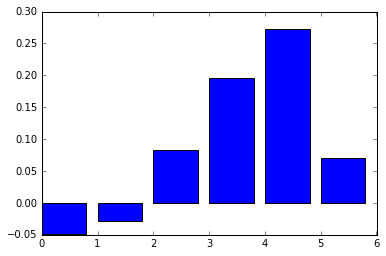

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.bar(range(len(preds)), preds)

Results are quite encouraging, now it's time to define a... let's say a *SCat Argument Determination Algorithm* to transform network output into words.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


<Container object of 6 artists>

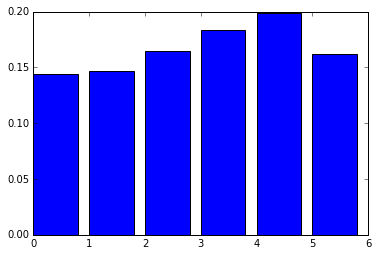

In [7]:
from torch.nn import functional as F

preds = Variable(torch.FloatTensor(preds))
preds = F.softmax(preds)
preds = [float(el) for el in preds]  # Back to list

plt.figure()
plt.bar(range(len(preds)), preds)

Here we have the probabilities of the word being the unique argument, I believe that argument word are the top word that have a combined probability of, at maximum, 50%, not 1% more.

In [8]:
prob_sum = 0
selected_words = []
words = s_x.copy()

while prob_sum < 0.5:
    max_index = preds.index(max(preds))
    prob_sum += preds.pop(max_index)
    selected_words.append(words.pop(max_index))

if prob_sum > 0.5:
    del selected_words[-1]

selected_words = sorted(selected_words, key=lambda x: s_x.index(x)) # Sort argument in the order of s_x
print(selected_words)

['Los', 'Angeles']


It work just fine ! Tried with many other example and the result are quite robust for the size of our training set.